In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.models import load_model
import cv2

In [2]:
# data = []
# label_train = []
# for i in range(0,4):
#     path = 'Dataset/Train/'+str(i)
#     img = os.listdir(path)
#     for j in img:
#         im = Image.open(path+"/"+j)
#         im = im.resize((120,120))
#         im = np.array(im)
#         data.append(im)
#         label_train.append(i)
# data = np.array(data)

In [3]:
model = load_model("custom_model_final_sigmoid_256.h5")

In [4]:
img = Image.open("rt_sign1.jpg")
img = img.resize((256,256))
img = np.array(img)
img1 = Image.open("st_sign.jpg")
img1 = img1.resize((256,256))
img1 = np.array(img1)
img = img/255
img1 = img1/255

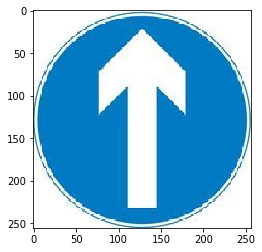

In [5]:
plt.imshow(img1)

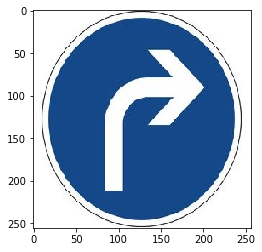

In [6]:
plt.imshow(img)

In [8]:
def frequency_filtering(img,hthsd_r,lthsd_r,hthsd_g,lthsd_g,hthsd_b,lthsd_b):
    r = tf.cast(img[:,:,0],"complex64")
    g = tf.cast(img[:,:,1],"complex64")
    b = tf.cast(img[:,:,2],"complex64")
    rh,rl = fourier(r,hthsd_r,lthsd_r)
    gh,gl=fourier(g,hthsd_g,lthsd_g)
    bh,bl = fourier(b,hthsd_b,lthsd_b)
    img_h = np.dstack((rh,gh,bh))
    img_l = np.dstack((rl,gl,bl))
    return img_h,img_l

In [9]:
def fourier(x,hthsd,lthsd):    
    fig,ax = plt.subplots(nrows=1,ncols=5)
    fft = tf.signal.fft2d(x)
    fft_shift = tf.signal.fftshift(fft)
    h_mask = fft_shift.numpy()
    h_mask[128-hthsd:128+hthsd,128-hthsd:128+hthsd]=0
    h=tf.signal.ifftshift(h_mask)
    x2 = tf.signal.ifft2d(h)
    x2 = tf.math.real(x2)
    l_mask = tf.zeros_like(fft_shift).numpy()
    l_mask[128-lthsd:128+lthsd,128-lthsd:128+lthsd]=fft_shift[128-lthsd:128+lthsd,128-lthsd:128+lthsd]
    l=tf.signal.ifftshift(l_mask)
    x1 = tf.signal.ifft2d(l)
    x1 = tf.math.real(x1)
    ax[0].imshow(tf.math.real(x),cmap="gray")
    ax[1].imshow(np.log1p(abs(l_mask)))
    ax[2].imshow(x1,cmap="gray")
    ax[3].imshow(np.log1p(abs(h_mask)))
    ax[4].imshow(x2,cmap="gray")
    return x2,x1

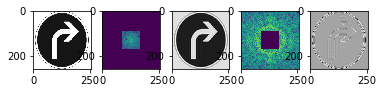

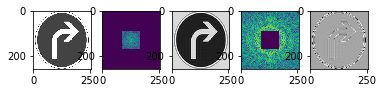

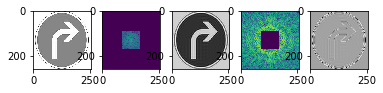

In [10]:
i1,i2 = frequency_filtering(img,40,40,40,40,40,40)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


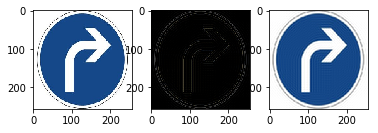

In [11]:
fig,ax = plt.subplots(nrows=1,ncols=3)
ax[0].imshow(img)
ax[1].imshow(i1)
ax[2].imshow(i2)

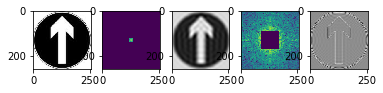

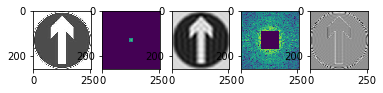

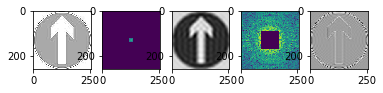

In [12]:
i11,i12 = frequency_filtering(img1,40,10,40,10,40,10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


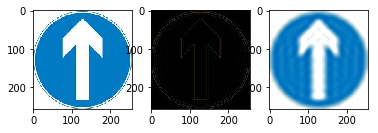

In [13]:
fig,ax = plt.subplots(nrows=1,ncols=3)
ax[0].imshow(img1)
ax[1].imshow(i11)
ax[2].imshow(i12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


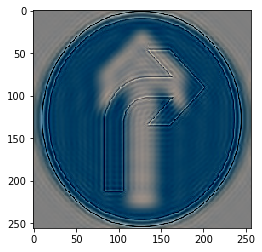

In [14]:
test = i1+i12/2
plt.imshow(test)

In [15]:
model(test.reshape(1,256,256,3))

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.00430905, 0.00835954, 0.00337325, 0.9839581 ]], dtype=float32)>

In [16]:
def frequency(img):
    r = tf.cast(img[:,:,0],"complex64")
    g = tf.cast(img[:,:,1],"complex64")
    b = tf.cast(img[:,:,2],"complex64")
    rm,rp = fourier_(r)
    gm,gp = fourier_(g)
    bm,bp = fourier_(b)
    return (rm,rp),(gm,gp),(bm,bp)

In [17]:
def fourier_(x):    
    fig,ax = plt.subplots(nrows=1,ncols=3)
    fft = tf.signal.fft2d(x)
    fft_shift = tf.signal.fftshift(fft)
    ax[0].imshow(tf.math.real(x),cmap="gray")
    ax[1].imshow(np.log1p(abs(fft_shift)))
    ax[2].imshow(tf.math.angle(fft_shift))
    return (abs(fft_shift)),(tf.math.angle(fft_shift))

In [18]:
def mag_ph(mag,ph):
    x = mag*tf.math.cos(ph)
    y = mag*tf.math.sin(ph)
    f = tf.complex(x,y)
    return f

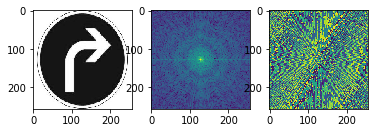

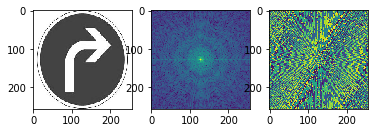

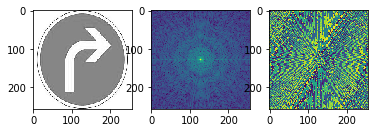

In [19]:
rf,gf,bf = frequency(img)

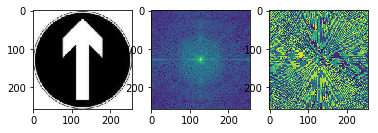

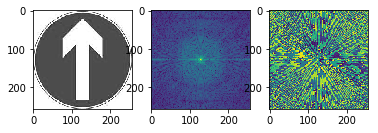

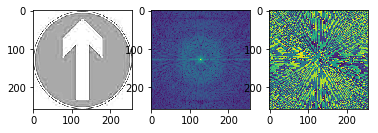

In [20]:
rf1,gf1,b1f = frequency(img1)

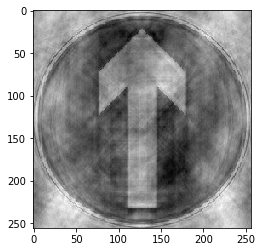

In [21]:
ft = mag_ph(rf[0],rf1[1])
ft = tf.signal.ifftshift(ft)
im = tf.signal.ifft2d(ft)
plt.imshow(tf.math.real(im),cmap="gray")

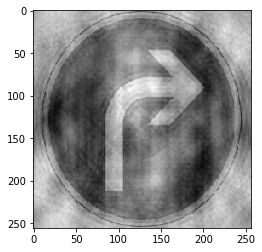

In [22]:
ft = mag_ph(rf1[0],bf[1])
ft = tf.signal.ifftshift(ft)
im = tf.signal.ifft2d(ft)
plt.imshow(tf.math.real(im),cmap="gray")

In [23]:
np.max(rf[1])# phase is in radians

3.1415927

In [23]:
# sns.heatmap(rf[1]-gf[1])

In [24]:
# sns.heatmap((rf[1]-rf1[1]))

In [7]:
generator = tf.keras.Sequential()
generator.add(tf.keras.layers.Dense(1000,input_shape=(100,),activation=tf.keras.layers.LeakyReLU()))
generator.add(tf.keras.layers.Dense(240,activation=tf.keras.layers.LeakyReLU()))
generator.add(tf.keras.layers.Reshape((20,12,1),input_shape = (240,)))
generator.add(tf.keras.layers.Conv2DTranspose(16,(5,5),activation=tf.keras.layers.LeakyReLU()))
generator.add(tf.keras.layers.Conv2DTranspose(32,(4,4),activation=tf.keras.layers.LeakyReLU()))
generator.add(tf.keras.layers.Conv2DTranspose(64,(3,3),activation=tf.keras.layers.LeakyReLU()))
generator.add(tf.keras.layers.Conv2DTranspose(128,(3,3),activation=tf.keras.layers.LeakyReLU()))
generator.add(tf.keras.layers.Conv2DTranspose(256,(2,2),activation="sigmoid"))
generator.add(tf.keras.layers.Reshape((256,256,3)))

In [8]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              101000    
_________________________________________________________________
dense_1 (Dense)              (None, 240)               240240    
_________________________________________________________________
reshape (Reshape)            (None, 20, 12, 1)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 24, 16, 16)        416       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 27, 19, 32)        8224      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 29, 21, 64)        18496     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 31, 23, 128)       7

In [9]:
tot_noise = 100
Z=[]
for i in range(tot_noise):
    noise = np.random.randn(10000)
    Z.append(noise)
Z=np.array(Z)
Z.shape

(100, 10000)

In [10]:
Z[:,1].reshape(-1,100,).shape

(1, 100)

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(0.001)
loss = tf.keras.losses.CategoricalCrossentropy()
target = [0,0,0,1]

In [12]:
# def loss2(x,win_size,c3):
#     sum1=0
#     m=0
#     y = tf.cast(tf.constant(img1)[:,:,0],"float32")
#     for i in range(0,121-win_size):
#         for j in range(0,121-win_size):
#             std_x = tf.math.reduce_std(x[i:i+win_size,j:j+win_size])
#             std_y = tf.math.reduce_std(y[i:i+win_size,j:j+win_size])
#             mean_x = tf.math.reduce_mean(x[i:i+win_size,j:j+win_size])
#             mean_y = tf.math.reduce_mean(y[i:i+win_size,j:j+win_size])
#             std_xy = tf.reduce_sum((x[i:i+win_size,j:j+win_size]-mean_x)*(y[i:i+win_size,j:j+win_size]-mean_y))/(win_size*win_size)
#             sum1+=(std_xy+c3)/((std_x*std_y)+c3)
#             m+=1
#     return sum1/m

In [13]:
# def loss2(noise,c3):
#     sum1=0
#     for i in range(3):
#         y = tf.cast(tf.constant(img)[:,:,i],"float32")
#         x = noise[:,:,i]
#         std_x = tf.math.reduce_std(x)
#         std_y = tf.math.reduce_std(y)
#         mean_x = tf.math.reduce_mean(x)
#         mean_y = tf.math.reduce_mean(y)
#         std_xy = tf.reduce_sum((x-mean_x)*(y-mean_y))/120*120
#         sum1+=((std_xy+c3)/((std_x*std_y)+c3))
#     return sum1

In [14]:
# def loss2(noise,c3):
#     sum1=0
#     sum2=0
#     for i in range(3):
#         y = tf.cast(tf.constant(img)[:,:,i],"float32")
#         x = noise[:,:,i]
#         std_x = tf.math.reduce_std(x)
#         std_y = tf.math.reduce_std(y)
#         mean_x = tf.math.reduce_mean(x)
#         mean_y = tf.math.reduce_mean(y)
#         std_xy = tf.reduce_sum((x-mean_x)*(y-mean_y))/120*120
#         sum2+=(2*std_x*std_y + c3)/((std_x*std_x)+(std_y*std_y)+c3)
#         sum1+=((std_xy+c3)/((std_x*std_y)+c3))
#     return sum1*sum2

In [15]:
# def loss2(noise,c3):
#     sum1=0
#     for i in range(3):
#         y = tf.cast(tf.constant(img)[:,:,i],"float32")
#         x = noise[:,:,i]
#         std_x = tf.math.reduce_std(x)
#         std_y = tf.math.reduce_std(y)
#         mean_x = tf.math.reduce_mean(x)
#         mean_y = tf.math.reduce_mean(y)
#         std_xy = -tf.reduce_sum((x-mean_x)*(y-mean_y))/(std_x*std_y)

#     return std_xy

In [16]:
# def loss2(noise):
#     loss_func=0
#     for i in range(3):
#         y = tf.cast(tf.constant(img)[:,:,i],"float32")
#         x = noise[:,:,i]
#         kernel1 = np.array([[1,-1]])
#         kernel2 = np.array([[-1,1]])
#         f1 = tf.nn.conv2d(tf.reshape(y,[1,256,256,1]),kernel1.reshape(1,2,1,1),[1,1,1,1],"SAME")[0,:,:,0]
#         f2 = tf.nn.conv2d(tf.reshape(y,[1,256,256,1]),kernel1.reshape(2,1,1,1),[1,1,1,1],"SAME")[0,:,:,0]
#         f3 = tf.nn.conv2d(tf.reshape(y,[1,256,256,1]),kernel2.reshape(1,2,1,1),[1,1,1,1],"SAME")[0,:,:,0]
#         f4 = tf.nn.conv2d(tf.reshape(y,[1,256,256,1]),kernel2.reshape(2,1,1,1),[1,1,1,1],"SAME")[0,:,:,0]
#         sum1 = tf.math.square(f1)+tf.math.square(f2)+tf.math.square(f3)+tf.math.square(f4)
#         sum2 = tf.math.square(x-y)
#         loss_func+=tf.math.reduce_variance((sum2-sum1))
#     return loss_func

In [ ]:
for epochs in range(1000):
    for ind in range(5000):
        z = Z[:,i].reshape(-1,100,)
        with tf.GradientTape() as gen_tape:
            generator.trainable = True
            yhat = model(generator(z))[0]
            print(yhat)
            gen_loss1 = loss(target,yhat)
            print(gen_loss1)
#             gen_loss2 = loss2(generator(z)[0])
            gen_loss = gen_loss1#+gen_loss2
        gradients_of_generator = gen_tape.gradient(gen_loss1, generator.trainable_variables)
        print(gradients_of_generator)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        print(epochs,ind,gen_loss1,gen_loss2)

In [ ]:
plt.imshow(generator(z)[0])

In [88]:
model(generator(z))

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.9058845 , 0.01593674, 0.00254585, 0.07563298]], dtype=float32)>

In [ ]:
nr,ng,nb=frequency(generator(z)[0])

In [ ]:
ah,al = frequency_filtering(generator(z)[0],40,40,40,40,40,40)

In [ ]:
bh,bl = frequency_filtering(img,40,40,40,40,40,40)

In [ ]:
test1 = bh+al
plt.imshow(test1)

In [ ]:
model(test1.reshape(1,120,120,3))

In [ ]:
model(img.reshape(1,120,120,3))

In [ ]:
im = Image.open("far.jpeg")
im = im.resize((120,120))
im = np.array(im)
im = im/255

In [ ]:
plt.imshow(im)

In [ ]:
model(im.reshape(1,120,120,3))